In [1]:
# 변수의 shape, type, value 확인
def p(var,_name="") :
    if _name != "" : print(f'<<{_name}>>')
    if type(var)!=type([]):
        try:      print(f'Shape:{var.shape}')
        except :  pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}')

def pst(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}')

ref:https://www.tensorflow.org/text/tutorials/transformer,
https://www.tensorflow.org/text/tutorials/transformer?hl=ko  


## Setup

In [ ]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

In [3]:
import logging
import time

import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams["font.size"] = "8"

tf.__version__,keras.__version__

('2.19.0', '3.10.0')

In [4]:
import tensorflow_text

## Data handling



### Download the dataset

TensorFlow 데이터세트 를 사용하여 TED Talks Open Translation Project 에서 포르투갈어-영어 번역 데이터 세트를 로드
* 약50000개의 training data, 1100개의 validation data 및 2000개의 test data 포함

https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en

In [5]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.BD5M7H_1.0.0/ted_hrlr_translate-tra…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.BD5M7H_1.0.0/ted_hrlr_translate-val…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.BD5M7H_1.0.0/ted_hrlr_translate-tes…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


text examples 쌍을 반환 함

In [28]:
for pt_examples, en_examples in train_examples.batch(3).take(1): #3개 짜리 batch를 한번
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(f":{pt.decode('utf-8')}")
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(f":{en.decode('utf-8')}")

> Examples in Portuguese:
:e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
:mas e se estes fatores fossem ativos ?
:mas eles não tinham a curiosidade de me testar .

> Examples in English:
:and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
:but what if it were active ?
:but they did n't test for curiosity .


### Set up the tokenizer

텍스트에서 직접 모델을 훈련할 수는 없고, 먼저 텍스트를 숫자 표현으로 변환함  
일반적으로 텍스트를 인덱스로 사용되는 토큰 ID 시퀀스로 변환함  
여기서는 데이터 세트에 최적화된 하위 단어 토크나이저로 `text.BertTokenizer`를 사용함  
- BertTokenizer: BERT 논문의 원래 토큰화 구현을 사용함  
 - Ref : https://www.tensorflow.org/text/guide/tokenizers

In [7]:
model_name = 'ted_hrlr_translate_pt_en_converter'
path = tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)
path

184801/184801 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


'./ted_hrlr_translate_pt_en_converter_extracted'

In [8]:
## vocabulary와 '분절 규칙'을 포함한 전처리 도구, parameter 없음
# 초기 설정 시에는 일종의 "훈련 과정" 통해 만들어진 결과물이기 때문에 넓은 의미에서는 "학습된 결과"
# SavedModel 포맷은 비신경망 컴포넌트에도 적용 가능 함
tokenizers = tf.saved_model.load(f"{path}/{model_name}")

`tokenizers.en' method list 확인  
- `tokenize` method : 문자열 batch를 토큰 ID의 패딩된 batch로 변환
 - 구두점을 분할하고 소문자로 변환하며 토큰화하기 unicode standardized 함  


In [9]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [34]:
p(en_examples)

Shape:(3,)
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Values: [b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'
 b'but what if it were active ?' b"but they did n't test for curiosity ."]


In [37]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


`tokenize`: text to token-IDs  

In [38]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


`detokenize`: token-IDs to text

In [39]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


`lookup` method : token-IDs to token text

In [41]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
p(tokens)
## subword 단위의 분절(subword segmentation)
# searchability : b'search', b'##ability',
# serendipity   : b's', b'##ere', b'##nd', b'##ip', b'##ity',

> This is the text split into tokens:
Shape:(3, None)
Type: <class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>
Values: <tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>


데이터 세트의 예시당 토큰 분포

In [42]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

...................................................

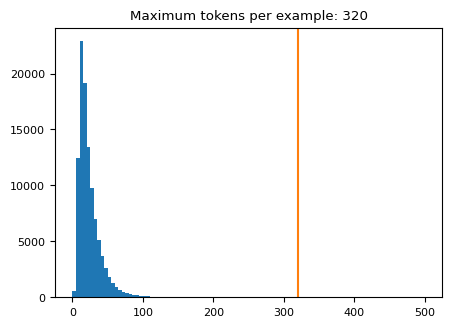

In [43]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

### Set up a data pipeline with `tf.data`

text batch를 학습에 적합한 형식으로 변환  
1. 비정형(ragged) batch로 토큰화  
 - ragged : 배치의 각 요소가 다른 모양 또는 길이를 갖는 데이터
2. `MAX_TOKENS`를 넘지 않도록 잘라냄  
3. target(영어)토큰을 입력과 출력으로 분할(one step shift)   
4. RaggedTensors를 padded dense Tensor S로 변환
5. (inputs, labels) 반환

In [44]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)# ragged batchs
    pt = pt[:, :MAX_TOKENS]        # Trim to MAX_TOKENS.
    pt = pt.to_tensor()            # 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()#[0:MAX_TOKENS-1]
    en_labels = en[:, 1:].to_tensor() #[1:MAX_TOKENS]
    return (pt, en_inputs), en_labels

dataset를 data pipeline으로 구성  

In [46]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [47]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

 </section>

### Test the Dataset

In [48]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)#(pt,en_inputs),en_labels
val_batches = make_batches(val_examples)

teacher forcing training :  
- 각 타임스텝에서 모델의 출력에 관계없이 다음 타임스텝에 대한 입력으로 실제 값(정답)을 가져옴.  
- 텍스트 생성 모델을 교육하는 간단하고 효율적임   

normal traning :    
- 추론 루프를 작성하고 모델의 출력을 다시 입력으로 전달   
- 더 느리고(시간 단계가 병렬로 실행될 수 없음)  
- 더 어려운 학습(문장의 끝을 바로 얻을 수 없음)  
- 더 안정적인 모델을 얻을 수 있음

<table>
<tr>
  <th>Inputs at the bottom, labels at the top.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

In [49]:
for (pt, en), en_labels in train_batches.take(1):
  break

ps(pt)       #(bs, s)
ps(en)       #(bs, ti[:-1])
ps(en_labels)#(bs, to[1:])

<<>> Shape(64, 45)
<<>> Shape(64, 48)
<<>> Shape(64, 48)


In [52]:
p(pt[0])

Shape:(45,)
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Values: [   2 5131 1879  343  381 6191   15  153  197  660   83 1092   16  106
  140   16    3    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]


shifted by 1:

In [ ]:
print(en[0][:10])
print(en_labels[0][:10])
#tf.Tensor([  2  87 168  13 186   9  55 112 184 218], shape=(10,), dtype=int64)
#tf.Tensor([ 87 168  13 186   9  55 112 184 218 663], shape=(10,), dtype=int64)

tf.Tensor([  2  45 217  50   9  56 405 851  76  13], shape=(10,), dtype=int64)
tf.Tensor([ 45 217  50   9  56 405 851  76  13  72], shape=(10,), dtype=int64)


## Define the components

### Positional encoding  

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [53]:
def positional_encoding(length, depth):          # (seq_len, 512)
  depth = depth/2
  positions = np.arange(length)[:, np.newaxis]   # (seq_len, 1): 0 ~ seq_len
  depths = np.arange(depth)[np.newaxis, :]/depth # (1, 256): 0 ~ 1

  angle_rates = 1 / (10000**depths)              # (1, 256): 1 ~ 1/(10000)
  angle_rads = positions * angle_rates           # (seq_len, 256)

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
  return tf.cast(pos_encoding, dtype=tf.float32) #(seq_len, [256,256])

(2048, 512)


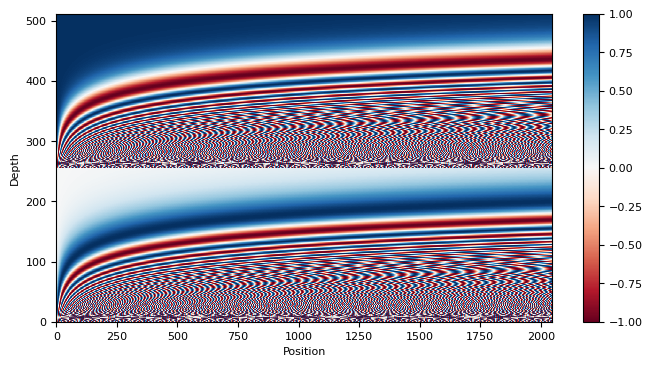

In [54]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.figure(figsize=(8,4))
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [ ]:
pos_encoding[:4,:32]

<tf.Tensor: shape=(4, 32), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.84147096, 0.8218562 , 0.8019618 , 0.7818871 , 0.7617204 ,
        0.7415398 , 0.7214141 , 0.70140374, 0.68156135, 0.66193265,
        0.6425569 , 0.62346786, 0.604694  , 0.58625925, 0.56818324,
        0.55048203, 0.53316844, 0.51625216, 0.49974045, 0.48363814,
        0.46794808, 0.4526713 , 0.4378073 , 0.4233542 , 0.4093089 ,
        0.3956674 , 0.38242462, 0.36957493, 0.35711193, 0.3450288 ,
        0.33331817, 0.32197243],
       [0.9092974 , 0.9364147 , 0.95814437, 0.9748882 , 0.98704624,
 

### Position Embedding  
토큰의 임베딩 벡터를 얻어오고, 위치 벡터를 추가하는 레이어

In [57]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    # d_model 차원에서는 분산이 d_model에 비례하여 커지므로 positonal_encoding의 분산과 비슷하게 하기 위해
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [123]:
#pt_vocab_size = 7765
#en_vocab_size = 7010

embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size().numpy(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size().numpy(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [124]:
ps(en)    # (64, 48)
ps(en_emb)# (64, 48, 512)

<<>> Shape(64, 48)
<<>> Shape(64, 48, 512)


In [125]:
# embedding처리에 masking이 포함되어 있음
p(en_emb._keras_mask)    # (64, 48)
p(en_emb._keras_mask[0])

Shape:(64, 48)
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Values: [[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]
Shape:(48,)
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Values: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]


###  scaled_dot_product_attention()  


In [126]:
def scaled_dot_product_attention(q, k, v, mask, pr=False):
    # q: query shape == (bs, num_heads, seq_len_q, v_dim/h)
    # k: key shape == (..., seq_len_k, v_dim/h)
    # v: value shape == (..., seq_len_v, depth_v)
    # mask: mask shape == (bs, 1, 1, seq_len_k). Defaults to None.

  # (..., seq_len_q, seq_len_k)
  matmul_qk = tf.matmul(q, k, transpose_b=True)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_att_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_att_logits += (mask * -1e9)

  # softmax is normalized on the seq_len_k. (..., seq_len_q, seq_len_k)
  att_weights = tf.nn.softmax(scaled_att_logits, axis=-1)
##  att_weights = dropout(att_weights)

  output = tf.matmul(att_weights, v)  # (..., seq_len_q, depth_v)
  if pr :
    print('matmul_qk is:\n', matmul_qk)
    print('dk is:\n',dk)
    print('scaled_att_logits is:\n',scaled_att_logits)
  return output, att_weights

`scaled_dot_product_attention` 출력 확인하기

In [127]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None, pr=True)
  print('\nAttention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

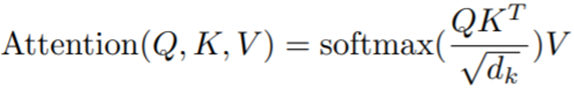

In [128]:
np.set_printoptions(suppress=True)

In [129]:
temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

In [130]:
print(temp_v)
print(tf.transpose(temp_k))

tf.Tensor(
[[   1.    0.]
 [  10.    0.]
 [ 100.    5.]
 [1000.    6.]], shape=(4, 2), dtype=float32)
tf.Tensor(
[[10.  0.  0.  0.]
 [ 0. 10.  0.  0.]
 [ 0.  0. 10. 10.]], shape=(3, 4), dtype=float32)


In [131]:
# second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

matmul_qk is:
 tf.Tensor([[  0. 100.   0.   0.]], shape=(1, 4), dtype=float32)
dk is:
 tf.Tensor(3.0, shape=(), dtype=float32)
scaled_att_logits is:
 tf.Tensor([[ 0.       57.735027  0.        0.      ]], shape=(1, 4), dtype=float32)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


matmul_qk is:  
 tf.Tensor([[  0. 100.   0.   0.]], shape=(1, 4), dtype=float32)  
dk is:  
 tf.Tensor(3.0, shape=(), dtype=float32)  
scaled_att_logits is:  
 tf.Tensor([[ 0.       57.735027  0.        0.      ]], shape=(1, 4), dtype=float32)  

Attention weights are:  
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)  
Output is:  
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)  

### Multi-head Attention

In [132]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads             # 8
    self.d_model = d_model                 # 512
    self.depth = d_model // self.num_heads # 64

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    # (bs, seq_len, 512) -> (bs, 8, seq_len, 64)
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    q = self.wq(q)  # (bs, seq_len, 512)
    k = self.wk(k)  # (bs, seq_len, 512)
    v = self.wv(v)  # (bs, seq_len, 512)
    q = self.split_heads(q, batch_size)  # (bs, 8, seq_len_q, 64)
    k = self.split_heads(k, batch_size)  # (bs, 8, seq_len_k, 64)
    v = self.split_heads(v, batch_size)  # (bs, 8, seq_len_v, 64)

    # scaled_attention.shape == (bs, 8, seq_len_q, 64)
    # attention_weights.shape == (bs, 8, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    ## (bs, seq_len_q, 8, 64)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    ## (bs, seq_len_q, 512)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))
    ## (bs, seq_len_q, 512)
    output = self.dense(concat_attention)
##    output = self.dropout(output)
    return output, attention_weights

In [133]:
## keras.layers.MultiHeadAttention() 이 만들어져 있음
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
print(out.shape)  # (1, 60, 512)
print(attn.shape) # (1, 8, 60, 60) : head별로 attention weight가 있음

(1, 60, 512)
(1, 8, 60, 60)


### Encoder Attention Layer  

In [134]:
## 속도를 위해서 keras lib.의 keras.layers.MultiHeadAttention 사용
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-7)
    self.add = tf.keras.layers.Add()

In [135]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        )
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [136]:
pt_emb = tf.random.uniform((64, 72, 512))

sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

ps(pt_emb)            #(64,72,512)
ps(sample_gsa(pt_emb))#(64,72,512)

<<>> Shape(64, 72, 512)
<<>> Shape(64, 72, 512)


### Decoder Attention Layer

In [137]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)##
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [138]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

ps(en_emb)            #(64,94,512)
ps(sample_csa(en_emb))#(64,94,512)

<<>> Shape(64, 48, 512)
<<>> Shape(64, 48, 512)


In [139]:
out1 = sample_csa(embed_en(en[:, :3])) #(64,3,512)
out2 = sample_csa(embed_en(en))[:, :3] #(64,3,512)

tf.reduce_max(abs(out1 - out2)).numpy()#4.7683716e-07

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'causal_self_attention_2' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


np.float32(0.000114917755)

### Cross Attention layer

In [140]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,       ##
        key=context,   ##
        value=context, ##
        return_attention_scores=True)
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [141]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

ps(pt_emb)                   #(bs, s, dim):(64,72,512)
ps(en_emb)                   #(bs, t, dim):(64,94,512)
ps(sample_ca(en_emb, pt_emb))#(bs, t, dim):(64,94,512)

<<>> Shape(64, 72, 512)
<<>> Shape(64, 48, 512)
<<>> Shape(64, 48, 512)


### Point(Position)-wise Feed Forward Network  
#### 각 token을 point(position)이라 함  
#### 각 token에 대해 개별적(독립적)으로 처리됨(parameter share)

In [142]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.ff = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'), # 2048
      tf.keras.layers.Dense(d_model),                # 512
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-7)

  def call(self, x): #(bs, seq_len, 512)
    x = self.add([x, self.ff(x)])
    x = self.layer_norm(x)
    return x         #(bs, seq_len, 512)

In [143]:
sample_ffn = FeedForward(512, 2048)

ps(en_emb)            #(64,84,512)
ps(sample_ffn(en_emb))#(64,84,512)

<<>> Shape(64, 48, 512)
<<>> Shape(64, 48, 512)


In [144]:
ps(sample_ffn.get_weights()[0]) #(512,2048)
ps(sample_ffn.get_weights()[2]) #(2048,512)

<<>> Shape(512, 2048)
<<>> Shape(2048, 512)


# Model

## Encoder Layer

In [145]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [146]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

ps(pt_emb)                      #(64,87,512)
ps(sample_encoder_layer(pt_emb))#(64,87,512)

<<>> Shape(64, 72, 512)
<<>> Shape(64, 72, 512)


## Encoder Block Layer

In [151]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)
    self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads,
                       dff=dff, dropout_rate=dropout_rate)for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs :(bs, seq_len)
    x = self.pos_embedding(x)  #(bs, seq_len, d_model)
    # Add dropout.
    x = self.dropout(x)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)
    return x  #(bs, seq_len, d_model)

Test the encoder:

In [152]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4, d_model=512,
                         num_heads=8, dff=2048, vocab_size=8500)
sample_encoder_output = sample_encoder(pt, training=False)
# Print the shape.
ps(pt)                   #(64,87)
ps(sample_encoder_output)#(64,87,512)

<<>> Shape(64, 45)
<<>> Shape(64, 45, 512)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_self_attention_35' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'encoder_layer_32' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


## Decoder Layer

In [154]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
    super(DecoderLayer, self).__init__()
    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
    self.cross_attention = CrossAttention(
        num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)
    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores
    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [155]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

ps(en_emb)                     #(64,84,512)
ps(pt_emb)                     #(64,87,512)
ps(sample_decoder_layer_output)#(64,84,512)

<<>> Shape(64, 48, 512)
<<>> Shape(64, 72, 512)
<<>> Shape(64, 48, 512)


## Decoder Block Layer

In [156]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads,
          dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]
    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs : (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)
    self.last_attn_scores = self.dec_layers[-1].last_attn_scores
    return x #(batch_size, target_seq_len, d_model)

In [157]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4, d_model=512,num_heads=8, dff=2048, vocab_size=8000)
output = sample_decoder(x=en, context=pt_emb)

# Print the shapes.
ps(en)    #(64,84)
ps(pt_emb)#(64,87,512)
ps(output)#(64,84,512)

<<>> Shape(64, 48)
<<>> Shape(64, 72, 512)
<<>> Shape(64, 48, 512)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'causal_self_attention_4' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'decoder_layer_1' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


## Transformer Model

In [159]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads,
                           dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)
    self.decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads,
                           dff=dff, vocab_size=target_vocab_size, dropout_rate=dropout_rate)
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    context, x  = inputs
    context = self.encoder(context)#(bs, context_len, d_model)
    x = self.decoder(x, context)   #(bs, target_len, d_model)
    logits = self.final_layer(x)   #(bs, target_len, target_vocab_size)
    # Return the final output and the attention weights.
    return logits

In [160]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [161]:
transformer = Transformer(
    num_layers=num_layers, # 4
    d_model=d_model,       # 128
    num_heads=num_heads,   # 8
    dff=dff,               # 512
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),#7765
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),#7010
    dropout_rate=dropout_rate) # 0.1

In [162]:
output = transformer((pt, en))
ps(en)     #(64,84)
ps(pt)     #(64,87)
ps(output) #(64,84,7010)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_self_attention_39' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'encoder_layer_36' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'causal_self_attention_8' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see th

<<>> Shape(64, 48)
<<>> Shape(64, 45)
<<>> Shape(64, 48, 7010)


In [167]:
#transformer.summary()

# Training

## Optimizer

논문에서 제시된 lernining rate scheduler:
- Warm Up scheduler  
$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$


In [168]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [169]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

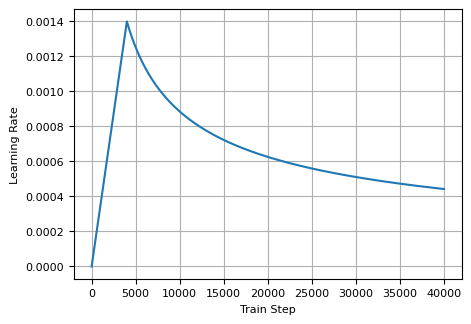

In [170]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.grid()
plt.xlabel("Train Step")

## Loss and metrics

Seq. 길이가 다르므로 수정된 loss, accuracy 함수가 필요함

In [171]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  matched = label == pred

  mask = label != 0
  matched = matched & mask

  matched = tf.cast(matched, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(matched)/tf.reduce_sum(mask)

## Train the model

In [172]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
%%time
my_callbacks = [ keras.callbacks.ModelCheckpoint(filepath="transformer.weights.h5",
                                                save_weights_only=True,
                                                save_best_only=True), ]

history = transformer.fit(train_batches,
                          epochs=40, callbacks=my_callbacks,
                          validation_data=val_batches)

V100: Wall time: 51min 26s  
L4  : Wall time: 1h 12min 24s

In [ ]:
transformer.load_weights("transformer")

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.plot(history.history["masked_accuracy"], label='acc')
plt.plot(history.history["val_masked_accuracy"], label='val_acc')
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.semilogy()
plt.grid()
plt.legend()
plt.show()

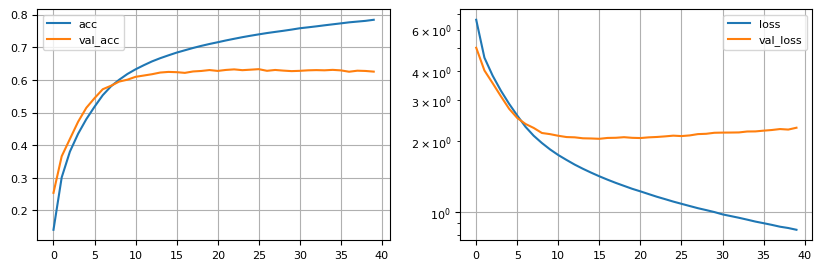

# Run inference

추론 절차 :  
* 포르투갈어 토크나이저(`tokenizers.pt`)를 사용하여 입력 문장을 인코딩  
* 디코더 입력은 `[START]` 토큰으로 초기화  
* 패딩 마스크와 Decoder 마스크 생성   
* '디코더'는 '인코더 출력'과 자체 출력(셀프 어텐션)을 보고 예측을 출력  
* 예측된 토큰을 디코더 입력에 연결하고 디코더에 전달   
* 이 접근 방식에서 디코더는 예측한 이전 토큰을 기반으로 다음 토큰을 예측   


In [ ]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer
  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    if len(sentence.shape) == 0: sentence = sentence[tf.newaxis] #(1,)<-()
    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
    encoder_input = sentence

    start_end = self.tokenizers.en.tokenize([''])[0] #(2,)<-(1,none) # empty string
    start = start_end[0][tf.newaxis] #(1,):2 = [START]
    end = start_end[1][tf.newaxis]   #(1,):3 = [END]

    # tf.TensorArray : instead of a Python list
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)
      predictions = predictions[:, -1:, :]  # (bs,last_token,7010)`.
      predicted_id = tf.argmax(predictions, axis=-1)
      output_array = output_array.write(i+1, predicted_id[0])
      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack()) #(1,tokens):[[13 23 234 ... ]]
    text = tokenizers.en.detokenize(output)[0]  #(): b'scholars adv...'
    tokens = tokenizers.en.lookup(output)[0]    #(tokens,):[b'[START]' b'scholars',...]

    # attention_weights를 얻기위해 한번더 실행(tf.function의 방해)
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [ ]:
translator = Translator(tokenizers, transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

Example 1:

In [ ]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem we need to solve .
Ground truth   : this is a problem we have to solve .


Example 2:

In [ ]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


Input:         : os meus vizinhos ouviram sobre esta ideia.  
Prediction     : my neighbors heard of this idea .  
Ground truth   : and my neighboring homes heard about this idea .  

Example 3:

In [ ]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m very quickly going to share with you some stories of some magic things that happen .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.  
Prediction     : so i ' m going to quickly share with you some magic stories that happened .  
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.  

## Create attention plots

In [ ]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


**Single-Head attention weight plot**


In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [ ]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

These are the input (Portuguese) tokens:

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

And these are the output (English translation) tokens:

In [ ]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

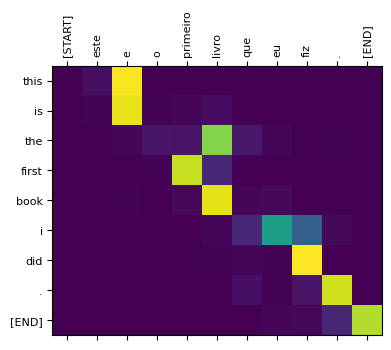

**Multi-Head attention weight plot**


In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

In [ ]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

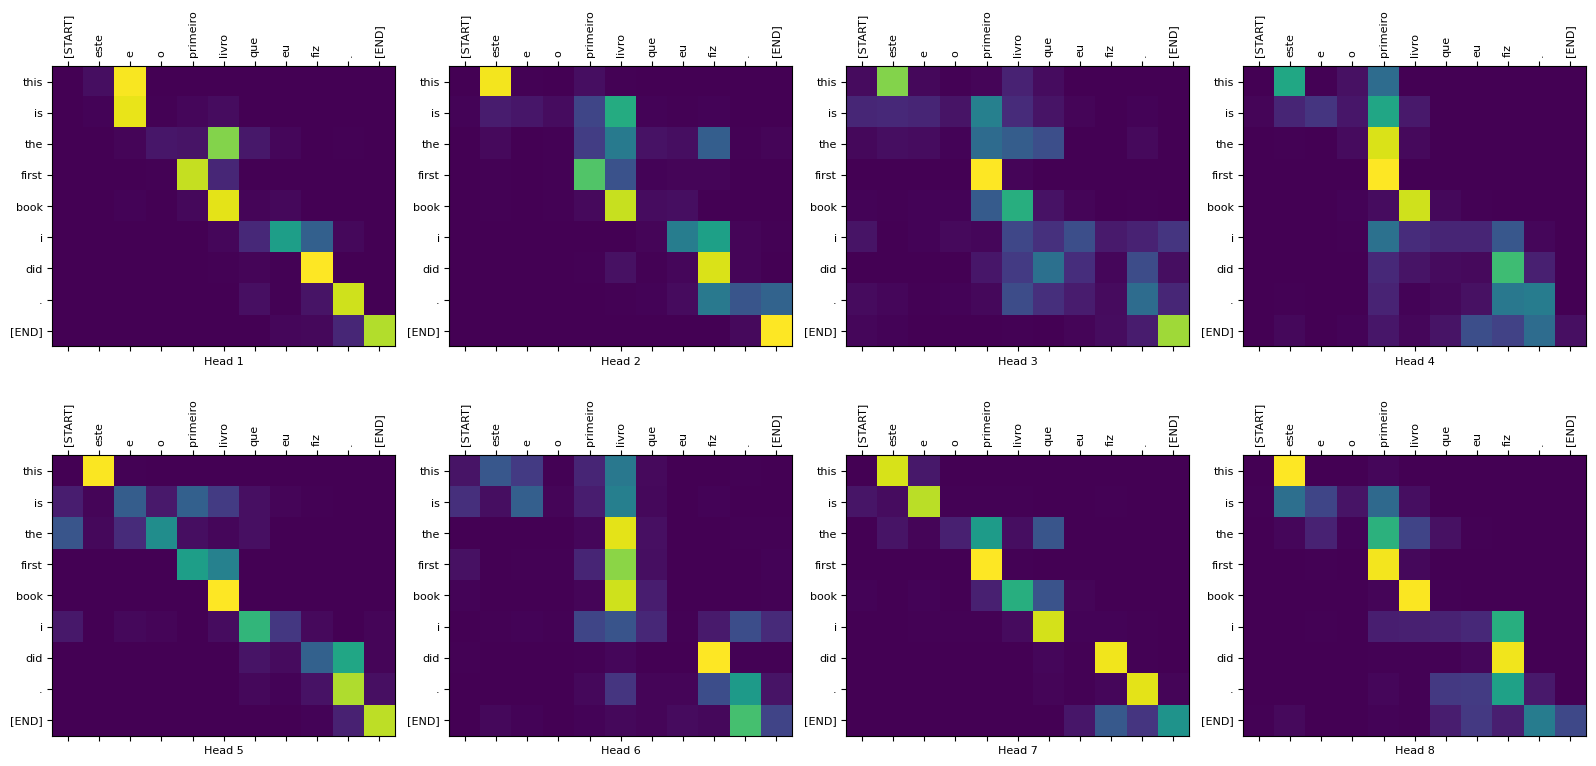

**학습하지 않은 단어 처리**  
'triceratops' 및 'encyclopédia' 모두 입력 데이터 세트에 없음  
모델은 공유 어휘 없이도 이를 음역하려고 시도함   

In [ ]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

Input:         : Eu li sobre triceratops na enciclopédia.  
Prediction     : i read about triviates in encyclopedia .  
Ground truth   : I read about triceratops in the encyclopedia.

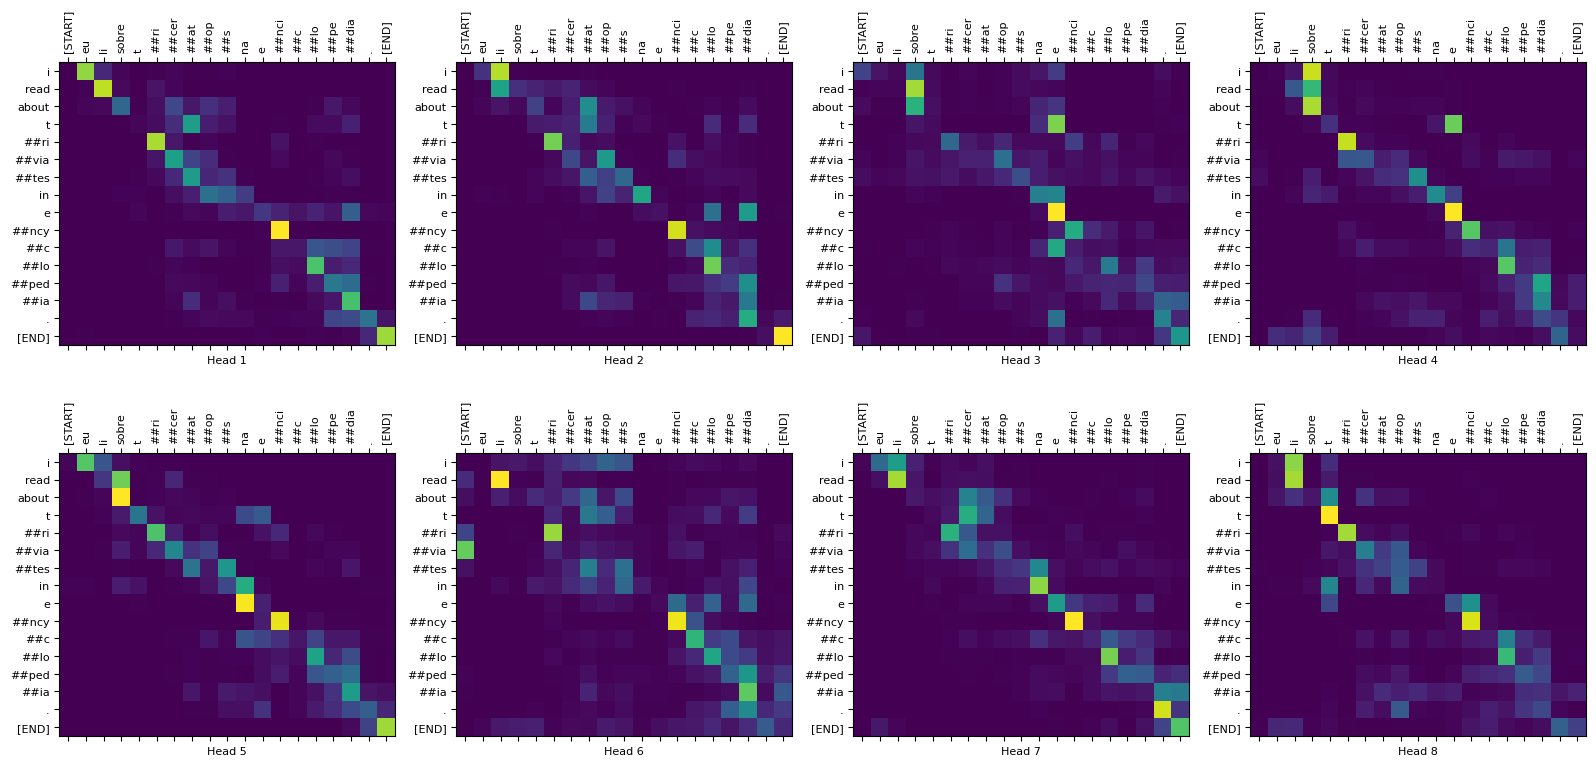